In [74]:
from units import *
import matplotlib.pyplot as plt
from astrometry_sim import QuasarSim
import healpy as hp
from pylab import cm as cmaps
from estimator_wholesky import get_vector_alm
from tqdm import *
from astropy import units as u
from pylab import rcParams
import matplotlib as mpl

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
mpl.rcParams['axes.linewidth'] = 1. #set the value globally

In [17]:
max_sep = 20
nside = 128
lmax = 3*nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True, 
                sim_uniform=True, nside=nside, calc_powerspecs=True, 
                do_alpha=True)

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3*kpc, R_max=260*kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.analysis_pipeline()

In [214]:
cmap = cmaps.Greys
cmap.set_under('w')

In [215]:
maxx = 10**(-3.5)
maxx_a = 10**(-10.5)

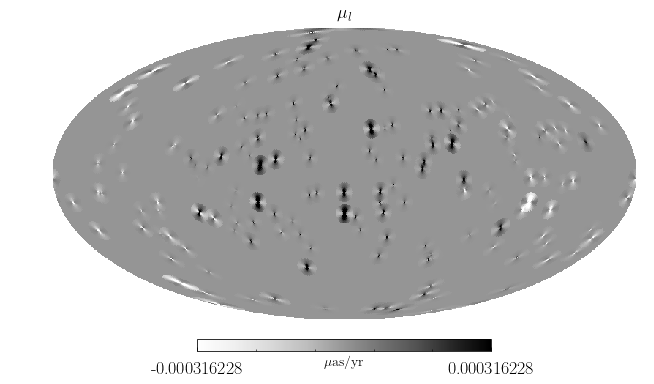

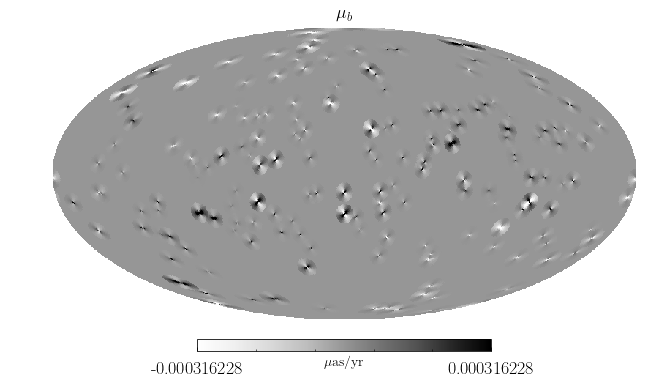

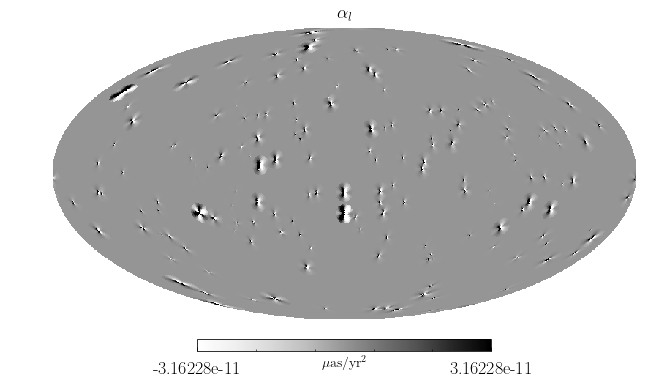

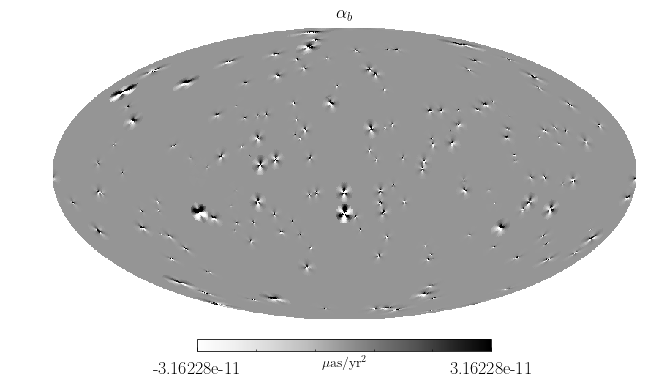

In [216]:
hp.mollview(1e6*sim.mu_qsrs[:,0],max=maxx, min=-maxx, title="$\mu_l$", unit='$\mu$as/yr', cmap=cmap)
hp.mollview(1e6*sim.mu_qsrs[:,1],max=maxx, min=-maxx, title="$\mu_b$", unit='$\mu$as/yr', cmap=cmap)
hp.mollview(1e6*sim.alpha_qsrs[:,0],max=maxx_a, min=-maxx_a, title="$\\alpha_l$", unit='$\mu$as/yr$^2$', cmap=cmap)
hp.mollview(1e6*sim.alpha_qsrs[:,1],max=maxx_a, min=-maxx_a, title="$\\alpha_b$", unit='$\mu$as/yr$^2$', cmap=cmap)

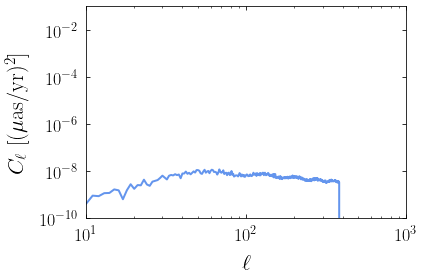

In [217]:
ell = np.arange(len(sim.Cl_B))

plt.plot(ell, ell*(ell+1)*(sim.Cl_B)/(2*ell + 1)/1e-12)

plt.yscale("log")
plt.xscale("log")
plt.xlim(10, 1000)
plt.ylim(1e-10,1e-1)
plt.ylabel("$C_\ell$ [($\mu$as/yr)$^2$]")
plt.xlabel("$\ell$")
plt.tight_layout()

np.save("temp",ell*(ell+1)*(sim.Cl_B)/(2*ell + 1)/1e-12)

In [218]:
lmin_plot = 10
lmax_plot = 300

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '$\\log_{10}(|\\Psi_{lm}|^2\\,[\\mu$as$^2$\\,yr$^{-2}])$')

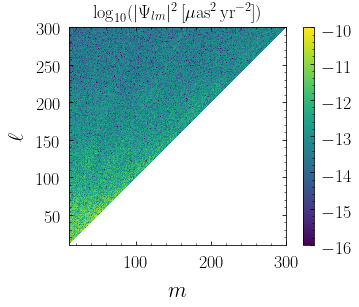

In [219]:
plt.imshow((np.log10((np.abs(sim.fB*1e6)**2)[lmin_plot:lmax_plot,lmin_plot:lmax_plot])), 
           origin='lower', vmin=-16, vmax=-10,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot]
          )
cbar = plt.colorbar()

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title("$\log_{10}(|\Psi_{lm}|^2\,[\mu$as$^2$\,yr$^{-2}])$")

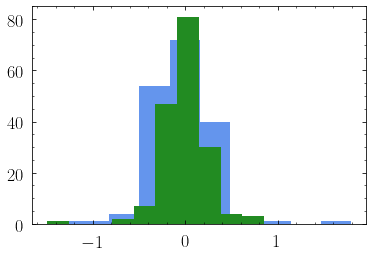

In [220]:
plt.hist(sim.coords_galactic.pm_l_cosb.value);
plt.hist(sim.coords_galactic.pm_b.value);

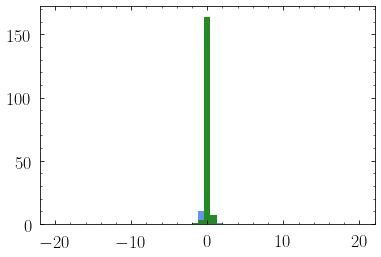

In [221]:
plt.hist(sim.coords_galactic.pm_l_cosb.value, bins=np.linspace(-20,20,50));
plt.hist(sim.coords_galactic.pm_b.value, bins=np.linspace(-20,20,50));

In [123]:
nch = 2
nsim = 200

ch_ary = np.zeros((nsim, nch, lmax))

for i in tqdm_notebook(range(nsim)):
    fB = np.load("/scratch/sm8383/QuasarSims/lcdm_" + str(i) + ".0.npz")['fB']
    ch_ary[i, :, :] = np.transpose([[np.mean(split_ary) for split_ary in np.array_split((np.abs(fB)**2)[l][:l], nch)] for l in range(lmax)])
    

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [124]:
ch_1 = 1e12*2*np.percentile(ch_ary[:,0,1:], [16,50,84], axis=0)
ch_2 = 1e12*2*np.percentile(ch_ary[:,1,1:], [16,50,84], axis=0)

ell = np.arange(1, len(ch_1[0]) + 2)

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


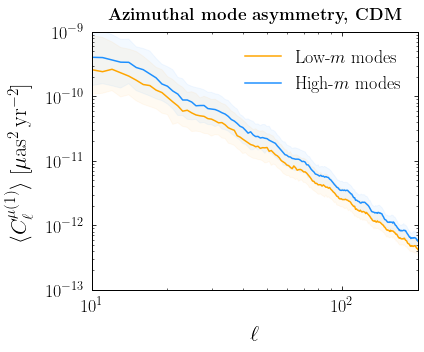

In [134]:
rcParams['figure.figsize'] = 6, 5

alpha_plot = 0.05
lw_plot = 1.5

plt.plot(ell[1:], ch_1[1], label="Low-$m$ modes", color='orange', lw = lw_plot)
plt.fill_between(ell[1:], ch_1[0], ch_1[2], alpha=alpha_plot, color='orange')

plt.plot(ell[1:], ch_2[1], label="High-$m$ modes", color='dodgerblue', lw = lw_plot)
plt.fill_between(ell[1:], ch_2[0], ch_2[2], alpha=alpha_plot, color='dodgerblue')

plt.xlim(10, 200)
plt.ylim(1e-13,1e-9)
plt.xscale("log")
plt.yscale("log")

plt.legend(frameon=False)

plt.title('\\textbf{Azimuthal mode asymmetry, CDM}', fontsize=17, y=1.02)

plt.xlabel("$\ell$")
plt.ylabel("$\langle C_\ell^{\\mu (1)}\\rangle$ [$\mu$as$^2$\,yr$^{-2}$]")

plt.tight_layout()
plt.savefig("../Plots/m_asymm_2.pdf")

In [126]:
fB_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(range(nsim)):
    fB = np.load("/scratch/sm8383/QuasarSims/lcdm_" + str(i) + ".0.npz")['fB']
    fB_ary += np.abs(fB*1e6)**2
fB_ary /= nsim

In [135]:
lmin_plot = 10
lmax_plot = 300

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


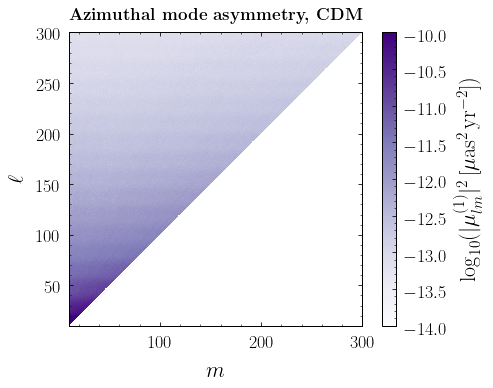

In [136]:
rcParams['figure.figsize'] = 7, 5.5

plt.imshow((np.log10((fB_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot])), 
           origin='lower', vmin=-14, vmax=-10,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap=plt.get_cmap('Purples')
          )
cbar = plt.colorbar(label="$\log_{10}(|\mu_{lm}^{(1)}|^2\,[\mu$as$^2$\,yr$^{-2}])$")

plt.xlabel("$m$")
plt.ylabel("$\ell$")

plt.title('\\textbf{Azimuthal mode asymmetry, CDM}', fontsize=17, y=1.02)

plt.tight_layout()
plt.savefig("../Plots/m_asymm_1.pdf")

In [138]:
fB_ary_compressed = (fB_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]

In [198]:
fB_ary_compressed_means = np.nanmean(np.where(fB_ary_compressed!=0,fB_ary_compressed,np.nan),axis=1)

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


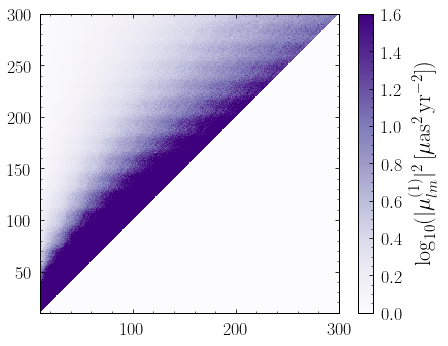

In [222]:
fB_ary_compressed_means = np.nanmean(np.where(fB_ary_compressed!=0,fB_ary_compressed,np.nan),axis=0)

plt.imshow(fB_ary_compressed/fB_ary_compressed_means, 
           origin='lower', vmin=0.0, vmax=1.6,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap=plt.get_cmap('Purples')
          )

cbar = plt.colorbar(label="$\log_{10}(|\mu_{lm}^{(1)}|^2\,[\mu$as$^2$\,yr$^{-2}])$")

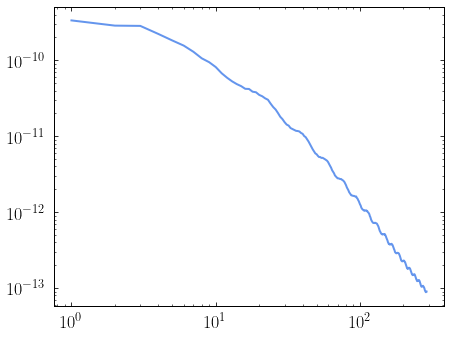

In [221]:
plt.plot(fB_ary_compressed_means)
plt.yscale("log")
plt.xscale("log")